The purpose of this notebook is to present the use of deep learning and especially convolution network and embedding with business data that includes transactions, categorical characteristcs of customers.
Through this post, we want to show that deep learning is a very efficient and practical technique especially through functional API to handle the different types of business data associated to use cases such as churn, product recommendation, behavior segmentation or even business forecasts.

Convolutional network have proven very useful to handle multi-dimensional temporal data, embeddings enable to represent meaningfully and automatically categorical attributes or sequence of attributes that were not considered in traditional predictive models. 

It is composed of 5 parts:
- Convolutional network to predict churn with semi-transactional usage data considered as image
- Fully connected and Convolutional Auto-encoders to segment the different usage behavior
- How Convnet sees the churn or the usage behavior
- Plan embedding to predict churn
- Multi-branch and hybrid churn model

References: 

Churn analysis using convolutional network and autoencoders https://arxiv.org/abs/1604.05377

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, concatenate
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D 
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils                                                                                                      
from keras.models import Sequential 


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
import numpy as np
import math
import pandas as pd
from sklearn import metrics
from sklearn.manifold import TSNE

%matplotlib inline

Using Theano backend.


# Data Import

All the data is provided in a single table that is build around daily usage for a full month per subscriber. The 12 fields from #outgoing calls to Cost represents daily aggregate for 31 days (one line per SUBSCRIBER_ID and Date) prior a churn assessment window of one month. This assessed churn is given in the CHURN column and is repeated 31 times of each subscriber only for convenience.

The plan characteristic is the latest plan of each subscriber and is repeated 31 times only for table convenience.

In [2]:
# The code was removed by DSX for sharing.

,SUBSCRIBER_ID,Date,CHURN_FLAG,Plan,# outgoing calls _normalized,# incoming calls _normalized,Sum duration incoming calls _normalized,Sum duration outgoing calls _normalized,Volume voice_normalized,Volume upload _normalized,Volume download_normalized,Duration data connection _normalized,# data connection _normalized,# MT SMS _normalized,# MO SMS _normalized,Cost_normalized
0,anon_S10001,2014-08-26,0,1,0.0,0.0,0.581818,0.0,0.0,0.0,0.0,0.265292,0.0,0.0,0.090670,0.0
1,anon_S10001,2014-08-27,0,1,0.0,0.0,0.290909,0.0,0.0,0.0,0.0,0.205503,0.0,0.0,0.106000,0.0
2,anon_S10001,2014-08-28,0,1,0.0,0.0,0.290909,0.0,0.0,0.0,0.0,0.305964,0.0,0.0,0.138628,0.0
3,anon_S10001,2014-08-29,0,1,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.658406,0.0,0.0,0.510277,0.0
4,anon_S10001,2014-08-30,0,1,0.0,0.0,0.254545,0.0,0.0,0.0,0.0,0.576213,0.0,0.0,0.028251,0.0


# Data Reshaping

As described above, the churn and the plan characteristics have only one value per subscriber. Hence, we can just aggregate through the max to obtain one row per subscriber.

In [3]:
Y_train = X_train.groupby(['SUBSCRIBER_ID'])['CHURN_FLAG'].agg({'CHURN':'max'})
Y_test = X_test.groupby(['SUBSCRIBER_ID'])['CHURN_FLAG'].agg({'CHURN':'max'}) 

Z_train = X_train.groupby(['SUBSCRIBER_ID'])['Plan'].agg({'Plan':'max'})
Z_test = X_test.groupby(['SUBSCRIBER_ID'])['Plan'].agg({'Plan':'max'})

Y_train.ix[0]

CHURN    0
Name: anon_S0, dtype: int64

Usage behavior as a picture: One multi-dimensional 31-day time series becomes one picture representing the usage behavior of one subscriber throughout the period of interest. Those pictures will be the input data to predict churn. As opposed to a traditional model where we would have had to take the average, max, min, slope across the 31 days, here we let the model decides which aggregation methods or representation of the time series is the most adapted to predict the churn.

In [4]:
img_rows, img_cols = 31, 12

X_train = X_train.ix[:,4:16].values
Y_train = Y_train.ix[:,0:1].values
X_test = X_test.ix[:,4:16].values
Y_test = Y_test.ix[:,0:1].values

print('X_train shape:', X_train.shape)                                                      
print(X_train.shape[0], 'train days')                                                    
print(X_test.shape[0], 'test days') 

X_train = X_train.reshape(X_train.shape[0]/31, img_rows, img_cols, 1)                          
X_test = X_test.reshape(X_test.shape[0]/31, img_rows, img_cols, 1)                             
X_train = X_train.astype('float32')                                                         
X_test = X_test.astype('float32')                                                           
#X_train /= 255                                                                              
#X_test /= 255                                                                               
print('X_train shape:', X_train.shape)                                                      
print(X_train.shape[0], 'train images')                                                    
print(X_test.shape[0], 'test images')  
Y_train = np_utils.to_categorical(Y_train, 2)                                      
Y_test = np_utils.to_categorical(Y_test, 2) 
print(Y_train.shape[0], 'train target images')                                                    
print(Y_test.shape[0], 'test target images')  


X_train shape: (298096, 12)
298096 train days
130262 test days
X_train shape: (9616, 31, 12, 1)
9616 train images
4202 test images
9616 train target images
4202 test target images


/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Data Visualization as Picture (Mosaique)

In [13]:
#definition of mosaique of pictures

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


inpic shape :  (36, 31, 12, 1)
inpic shape :  (36, 31, 12)


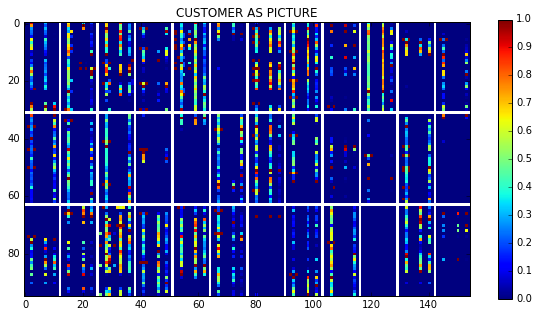

In [157]:
inpic = X_train[0:36]
pl.figure(figsize=(10, 5))
pl.title('BEHAVIOR AS PICTURE')
im = pl.imshow(make_mosaic(inpic,3,12),interpolation='nearest', cmap=None)
pl.colorbar(im)

# Supervised Convolutional network 
We are looking at 2 layer of convolutions, one considering 1 week of data together per variable (filter size 14,1) and the other considering all the variables together per aggregated time step (filter size 1,12). 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 31, 12, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 25, 12, 5)         40        
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 1, 5)          305       
_________________________________________________________________
flatten_12 (Flatten)         (None, 125)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 5)                 630       
_________________________________________________________________
prediction (Dense)           (None, 2)                 12        
Total params: 987
Trainable params: 987
Non-trainable params: 0
_________________________________________________________________
Train on 961

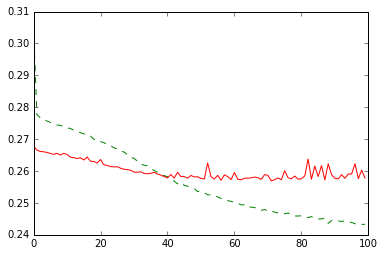

In [158]:
input_1 =  Input(shape=(31,12,1), name = "input_1")

x1 = Convolution2D(5, (7, 1), padding='valid',input_shape=(31, 12, 1), activation = 'relu', name = "conv1")(input_1)
x1 = Convolution2D(5, (1, 12), padding='valid',input_shape=(25,12,10), activation = 'relu', name = "conv2")(x1)
x1 = Flatten()(x1)
x1 = Dense(5,activation = 'relu', name = "Dense1")(x1)
prediction = Dense(2,activation = 'softmax', name = "prediction")(x1)


model = Model(inputs=input_1, outputs=prediction)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=["accuracy"])                        

my_model = model.fit(X_train, Y_train, batch_size=10, epochs=100, verbose=0, validation_data=(X_test, Y_test))

#AUC Calculation
s_test = model.predict(X_test, batch_size=10, verbose=0)[:,1]
s_train = model.predict(X_train, batch_size=10, verbose=0)[:,1]
auc_test = metrics.roc_auc_score(Y_test[:,1], s_test)
print('AUC test',auc_test)
auc_train = metrics.roc_auc_score(Y_train[:,1], s_train)
print('AUC train',auc_train)

plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

# Autoencoder (Fully connected one layer)
In order to get very simple segments of usage behavior, we first use a simple fully connected autoencoder and we later check with the pictures how well it performs.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 1, 372)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1, 5)              1865      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 372)            2232      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


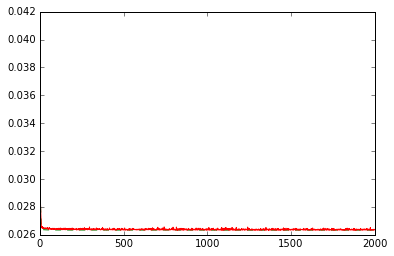

In [159]:
X_train_encoder = X_train.reshape(-1,1,31*12)                           
X_test_encoder = X_test.reshape(-1,1,31*12)


input_img = Input(shape=(1,31*12))
encoded = Dense(5,activation='relu',input_shape = (1,31*12))(input_img)
decoded = Dense(31*12,activation = 'linear')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()


rms = RMSprop() 
autoencoder.compile(loss='mean_squared_error', optimizer=rms)
my_model = autoencoder.fit(X_train_encoder, X_train_encoder, epochs = 2000, batch_size=128, verbose = False, shuffle=True, validation_data=(X_test_encoder, X_test_encoder))

plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')



It is interesting to look if the decoder is able to reconstruct the image after the bottleneck of the Dense layer. We see that with a simple fully connected layer, the reconstruction is far from perfect. However the main patterns are learnt. One interesting observation is that as soons as the network seens an observation in one of the columns, it assumes that it is true for almost the whole 31 days period. So in a way the temporal pattern are not fully captured.

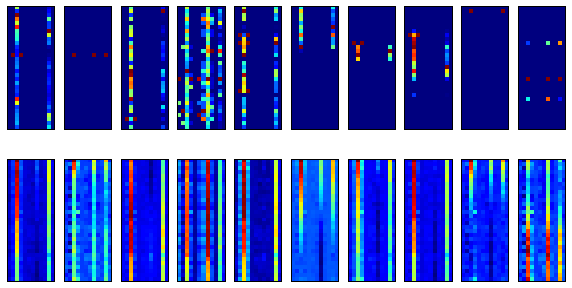

In [160]:
decoded_imgs = autoencoder.predict(X_test_encoder)

n = 10
plt.figure(figsize=(10, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[260+i].reshape(31, 12),interpolation = 'nearest', cmap = None)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[260+i].reshape(31, 12),interpolation = 'nearest', cmap = None)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In order to understand what are the typical profile, we can look at which profiles/pattern are captured in the intermediate layer. In other words we are looking at which pictures are maximizing the activation of the hidden layer of the network. In the case of the fully connected network, the input pixels are given by formula which we can find http://deeplearning.stanford.edu/wiki/index.php/Visualizing_a_Trained_Autoencoder

In [164]:
for layer in autoencoder.layers:
    weights = layer.get_weights()

W = weights[0]

adj_W = np.zeros(W.shape) 
for i in range(0,5):
    sqr_ss = np.sqrt(np.sum(W[i,:]*W[i,:])) 
    for j in range(0,31*12-1):
        adj_W[i,j] = (W[i,j])/sqr_ss

We observe different patterns maximizing the activation of the 5 different nodes:
- Increasing but low sum of incoming calls duration, sum of data duration and SMS incoming (except data duration high) 
- Outgoing calls, volume upload and download, # data connection
- incoming calls, outgoing calls on specific alternate day
- Decreasing and High sum of incoming calls duration, sum of data duration and SMS incoming
- Increasing then decreasing incoming calls duration and SMS incoming, very low data duration 

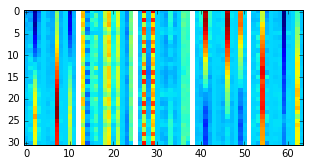

In [181]:
adj_W = adj_W.reshape(5,31,12)
pl.figure(figsize=(5, 5))
pl.imshow(make_mosaic(adj_W,1, 5), interpolation='nearest', cmap=None)

We have seen that the simple fully connected could help us see simple patterns in the data but we also see that the decoder is not fully capable of reconstructing the behavior. Hence the need to try out more advanced type of network such as convolutional autoencoder. For this specific case and to simplify the size of the filter we would use, we are only taking the last 28 days of the picture instead of 31 days.

In [6]:
X_train_encoder = X_train[:,:28,:,:]                        
X_test_encoder = X_test[:,:28,:,:]                                                                                                                                                                   
print('X_train shape:', X_train_encoder.shape)                                                      
print(X_train_encoder.shape[0], 'train images')                                                    
print(X_test_encoder.shape[0], 'test images')  

X_train shape: (9616, 28, 12, 1)
9616 train images
4202 test images


The autoencoder must be able to reconstruct the image properly while reducing the dimension significantly at the level of the bottleneck. We are using maxpooling to reduce the dimension at the encoder side and upsampling to increase the dimension at the decoder side. Hence, as opposed to our first convolutional network, the padding remains the same throughout the convolution filters.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 12, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 12, 3)         24        
_________________________________________________________________
maxP1 (MaxPooling2D)         (None, 7, 12, 3)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 12, 3)          111       
_________________________________________________________________
maxP2 (MaxPooling2D)         (None, 7, 3, 3)           0         
_________________________________________________________________
deconv1 (Conv2D)             (None, 7, 3, 3)           111       
_________________________________________________________________
UpS1 (UpSampling2D)          (None, 7, 12, 3)          0         
__________

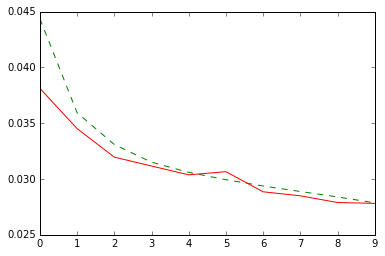

In [7]:
input_img = Input(shape=(28,12,1))
x = Convolution2D(3, (7, 1), activation='relu', padding = 'same', name = 'conv1')(input_img)
x = MaxPooling2D((4, 1), padding ='same', name = 'maxP1')(x)
x = Convolution2D(3, (1, 12), activation='relu', padding = 'same', name = 'conv2')(x)
encoded = MaxPooling2D((1, 4), padding ='same', name = 'maxP2')(x)

x = Convolution2D(3, (1, 12), activation='relu', padding = 'same', name = 'deconv1')(encoded)
x = UpSampling2D((1, 4), name = 'UpS1')(x)
x = Convolution2D(3, (7, 1), activation='relu', padding = 'same', name = 'deconv2')(x)
x = UpSampling2D((4, 1), name = 'UpS2')(x)

decoded = Convolution2D(1, (7, 12), activation='linear', padding = 'same', name = 'deconv3')(x)


autoencoder = Model(input_img, decoded)
autoencoder.summary()


rms = RMSprop() 
autoencoder.compile(loss='mean_squared_error', optimizer=rms)
my_model = autoencoder.fit(X_train_encoder, X_train_encoder, epochs = 10, batch_size=128, verbose = False, shuffle=True, validation_data=(X_test_encoder, X_test_encoder))

plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

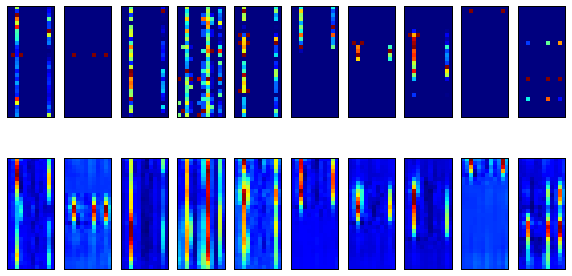

In [7]:
decoded_imgs = autoencoder.predict(X_test_encoder)

n = 10
plt.figure(figsize=(10, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_encoder[260+i].reshape(28, 12),interpolation = 'nearest', cmap = None)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[260+i].reshape(28, 12),interpolation = 'nearest', cmap = None)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

#     # convert to RGB array
#     x *= 255
#     x = x.transpose((1, 2, 0))
#     x = np.clip(x, 0, 255).astype('uint8')
    return x

0.673318899929
(28, 12)


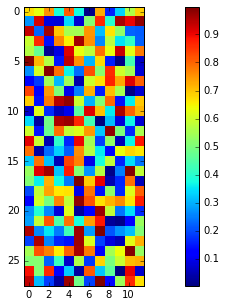

In [22]:
input_img_data1 = np.random.random((1, 28, 12,1))
pl.figure(figsize=(15, 5))
print(input_img_data1[0][0][0][0])
print(np.squeeze(input_img_data1).shape)
im = pl.imshow(np.squeeze(input_img_data1), interpolation='nearest')
pl.colorbar(im)

In [40]:
layer = autoencoder.get_layer("deconv1")
layer_output = layer.output

In [41]:
kept_filters = []

input_img_data1 = np.random.random((1, 28, 12,1))
input_img_data = input_img_data1

for i in range(0,3):
    input_img_data = np.zeros(28*12).reshape(1,28,12,1)  
    input_img_data = input_img_data1
    loss = K.mean(layer_output[:, :, :, i])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    iterate = K.function([input_img], [loss, grads])

    step = 1

    for i in range(1000):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break


            # decode the resulting input image
    if loss_value > 0:
        print("yes")
        img = deprocess_image(input_img_data[0])
        kept_filters.append(img)

yes
yes
yes


(3, 28, 12)


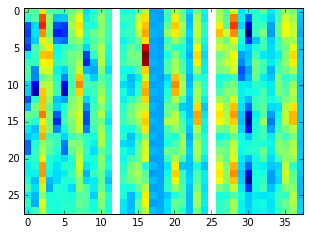

In [42]:
C1 = np.squeeze(np.array(kept_filters[0:3]))

pl.figure(figsize=(5, 5))
pl.imshow(make_mosaic(C1, 1, 3), interpolation='nearest',cmap=None)

In [11]:
encoder = Model(input_img,encoded)
encoded_imgs = encoder.predict(X_train_encoder)
encoded_imgs.shape
model = TSNE(n_components=2, random_state=0,perplexity = 100)
X_2d = model.fit_transform(encoded_imgs.reshape(encoded_imgs.shape[0],7*3*3))

In [9]:
np.squeeze(Y_train[:,0]).shape
#X_2d.shape
Y_train.astype(np.int64)
X_2d[:,0].shape
Y_train.astype(np.int64)[:,0].shape

(9616,)

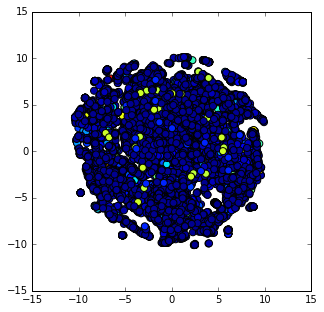

In [10]:
plt.rcParams['figure.figsize'] = 5, 5
#plt.scatter(X_2d[:,0], X_2d[:,1], s=50, c = Y_train.astype(np.int64)[:,0])
plt.scatter(X_2d[:,0], X_2d[:,1], s=50, c = Z_train.astype(np.int64))

In [153]:
model = TSNE(n_components=2, random_state=0,perplexity = 100)
X_2d = model.fit_transform(X_train_encoder.reshape(X_train_encoder.shape[0],28*12))

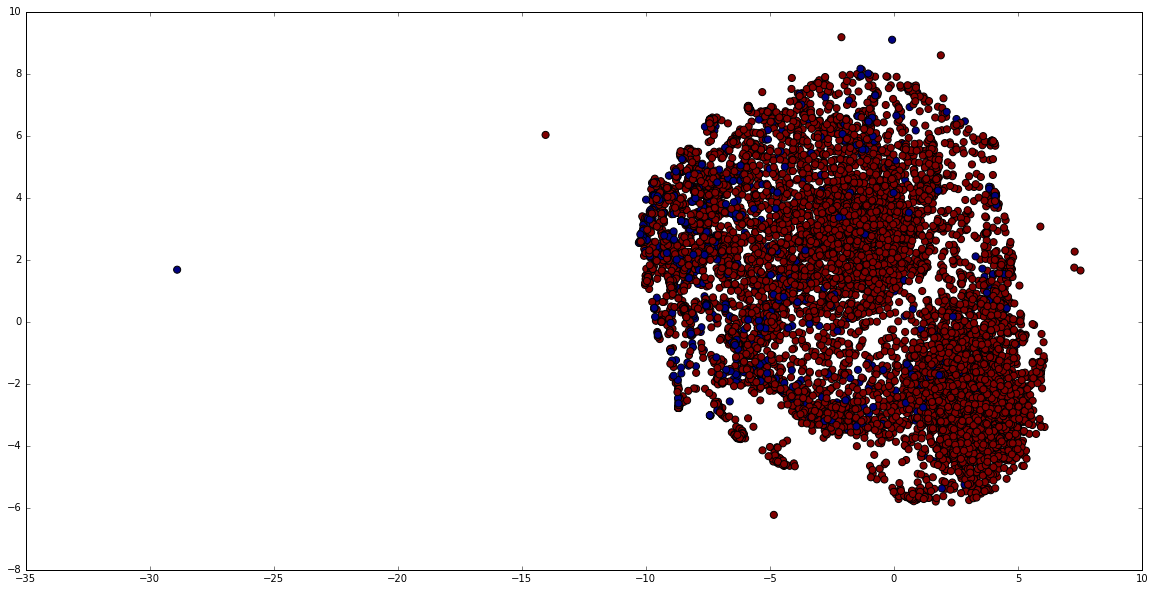

In [154]:
plt.rcParams['figure.figsize'] = 20, 10
plt.scatter(X_2d[:,0], X_2d[:,1], s=50, c = Y_train.astype(np.int64)[:,0])

In [99]:
pd.concat([Z_train,Z_test]).describe()

ValueError: incompatible categories in categorical concat

In [98]:
Z_train.Plan = pd.Categorical(Z_train.Plan)
Z_test.Plan = pd.Categorical(Z_test.Plan)

Z_train['index'] = Z_train.Plan.cat.codes
Z_test['index'] = Z_test.Plan.cat.codes

Plan_train = Z_train.ix[:,1:2].values
Plan_test = Z_test.ix[:,1:2].values

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Softmax.0, inputs=/input_19)`


AUC test 0.631860116036
AUC train 0.748357632279


130.34675382793648

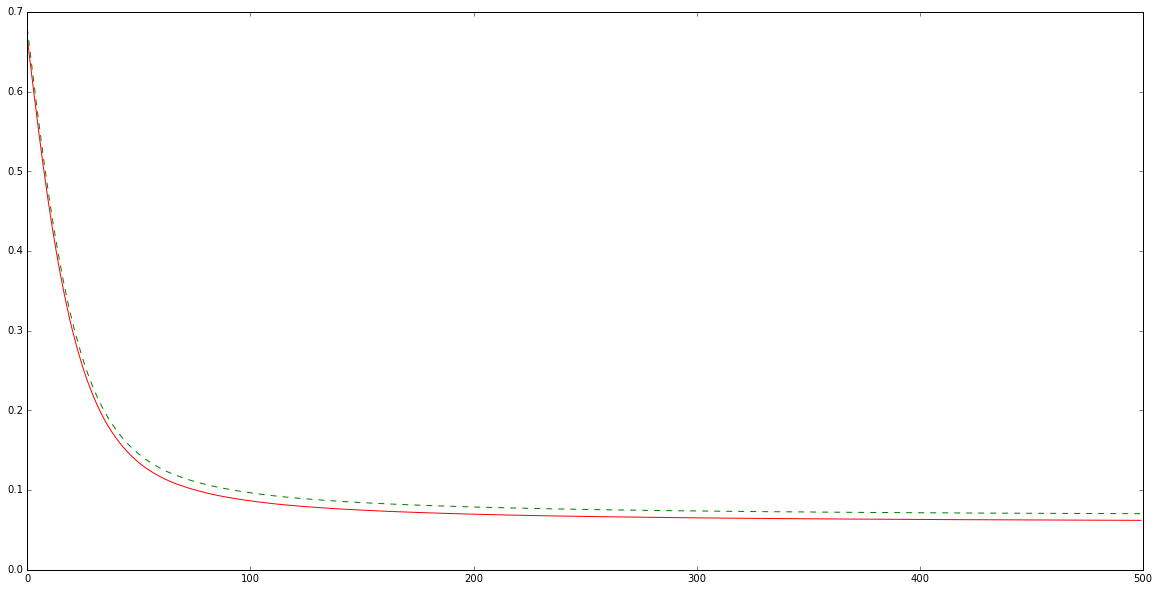

In [126]:
from keras.layers import Input, Embedding, Reshape, Dense
from keras.models import Model

input1 = Input(shape=(1,))
x = Embedding(input_dim=56,output_dim=2)(input1)
x = Reshape((2,),name="reshaped_embedding")(x)
prediction = Dense(2,activation='softmax',name='out',trainable=False)(x)

model = Model(input=input1, output=prediction)

model.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=["accuracy"])
my_model = model.fit(Plan_train,Y_train,batch_size=10, epochs = 500, verbose=False, validation_data = (Plan_test, Y_test))


plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

s_test = model.predict(Plan_test, batch_size=10, verbose=0)[:,1]
s_train = model.predict(Plan_train, batch_size=10, verbose=0)[:,1]
auc_test = metrics.roc_auc_score(Y_test[:,1], s_test)
print('AUC test',auc_test)
auc_train = metrics.roc_auc_score(Y_train[:,1], s_train)
print('AUC train',auc_train)
sum(s_train)


In [81]:
model.predict(Plan_test, batch_size=10, verbose=0)[:,1]

array([ 0.2132915,  0.2132915,  0.2132915, ...,  0.2132915,  0.2132915,
        0.2132915], dtype=float32)

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{2}..., inputs=/input_19)`
  if __name__ == '__main__':


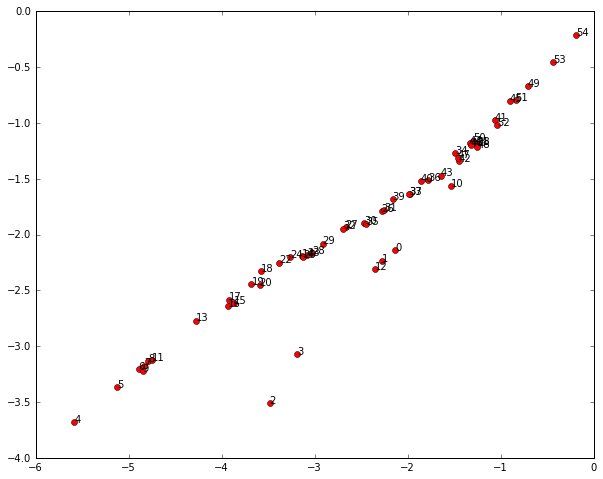

In [127]:
model_intermediary = Model(input=input1, output=model.get_layer("reshaped_embedding").output)

coords=pd.DataFrame(model_intermediary.predict(np.arange(55)))


fig, ax = plt.subplots(figsize=(10,8))
ax.plot(coords[0],coords[1],"ro")

for i, txt in enumerate(np.arange(55)):
    ax.annotate(i, (coords[0][i],coords[1][i]))

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{2}..., inputs=/input_17)`
  if __name__ == '__main__':


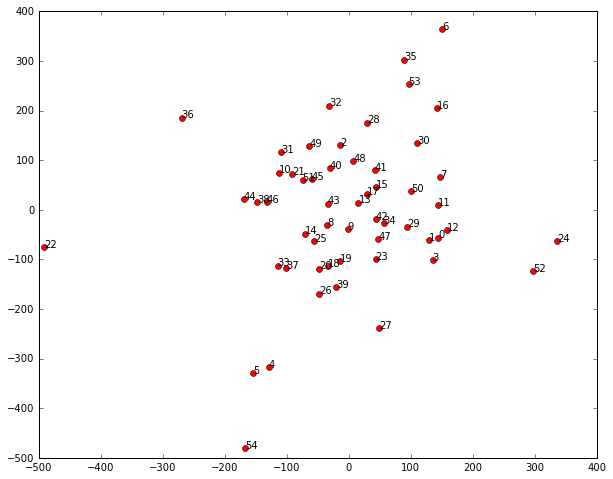

In [124]:
model_intermediary = Model(input=input1, output=model.get_layer("reshaped_embedding").output)

coords=pd.DataFrame(model_intermediary.predict(np.arange(55)))

model_tsne = TSNE(n_components=2, random_state=0,perplexity = 1)
X_2d = model_tsne.fit_transform(coords)


fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X_2d[:,0],X_2d[:,1],"ro")

for i, txt in enumerate(np.arange(55)):
    ax.annotate(i, (X_2d[i,0],X_2d[i,1]))


# CNN + EMBEDDING

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 31, 12, 1)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 18, 12, 5)     75                                           
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
conv2 (Conv2D)                   (None, 18, 1, 5)      305                                          
___________________________________________________________________________________________

84.172211106919747

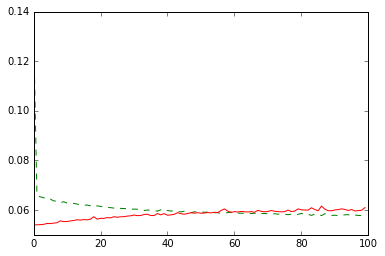

In [139]:
input_1 =  Input(shape=(31,12,1), name = "input_1")

x1 = Convolution2D(5, (14, 1), padding='valid',input_shape=(31, 12, 1), activation = 'relu', name = "conv1")(input_1)
x1 = Convolution2D(5, (1, 12), padding='valid',input_shape=(25,12,10), activation = 'relu', name = "conv2")(x1)
x1 = Flatten()(x1)
#x1 = Dense(5,activation = 'relu', name = "Usage")(x1)
#x1 = Dense(2,activation = 'softmax', name = "Dens2")(x1)

input_2 = Input(shape=(1,), name = "input_2")
x2 = Embedding(input_dim=56,output_dim=2)(input_2)
x2 = Reshape((2,),name="Plan_embedding")(x2)

x6 = concatenate([x1, x2], axis=1)
x6 = Dense(5, activation = 'relu')(x6)
prediction = Dense(2,activation = 'softmax', name = "prediction")(x6)


model = Model(inputs=[input_1,input_2], outputs=prediction)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=["accuracy"])
my_model = model.fit([X_train,Plan_train],Y_train,batch_size=10, epochs = 100, verbose=False, validation_data = ([X_test,Plan_test], Y_test))


plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

s_test = model.predict([X_test,Plan_test], batch_size=10, verbose=0)[:,1]
s_train = model.predict([X_train,Plan_train], batch_size=10, verbose=0)[:,1]
auc_test = metrics.roc_auc_score(Y_test[:,1], s_test)
print('AUC test',auc_test)
auc_train = metrics.roc_auc_score(Y_train[:,1], s_train)
print('AUC train',auc_train)
sum(s_train)